In [276]:
import pandas as pd
import numpy as np
import os
import sys
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
import matplotlib.patches as patches
from statsbombpy import sb
from statsbombpy.api_client import NoAuthWarning
from collections import Counter

In [277]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))
warnings.simplefilter(action='ignore', category=(FutureWarning))
warnings.simplefilter(action='ignore', category=NoAuthWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [278]:
parent_dir = os.path.abspath(os.path.join(os.path.dirname("./"), '..'))
sys.path.append(parent_dir)
from tools.lineup_tpr import LineupTPR

<br><br><br><br><br><br><br><br>
<h2 style="color:black;background:white;">Start</h2>

In [279]:
defense = pd.read_csv("../match_logs/Big5@22-23@defense.csv")
gca = pd.read_csv("../match_logs/Big5@22-23@gca.csv")
keeper = pd.read_csv("../match_logs/Big5@22-23@keeper.csv")
misc = pd.read_csv("../match_logs/Big5@22-23@misc.csv")
passing = pd.read_csv("../match_logs/Big5@22-23@passing.csv")
passing_types = pd.read_csv("../match_logs/Big5@22-23@passing_types.csv")
possession = pd.read_csv("../match_logs/Big5@22-23@possession.csv")
shooting = pd.read_csv("../match_logs/Big5@22-23@shooting.csv")

In [280]:
pd.read_csv("../players_db/fm23/fm23db_processed.csv").sort_values(by="tpr",ascending=False)[["Club","Name","Best_Pos","tpr"]].head(5)

,Club,Name,Best_Pos,tpr
3,FC Bayern,Manuel Neuer,GK,92
4164,FC Barcelona,Robert Lewandowski,ST,92
3193,Manchester City,Erling Haaland,ST,90
3195,Tottenham Hotspur,Harry Kane,ST,90
4172,FC Barcelona,Marc-André ter Stegen,GK,89


In [281]:
player_df = pd.read_csv("../players_db/fm23/fm23db_processed.csv")

In [282]:
team_df = pd.read_csv("../players_db/fm23/team_ratings.csv")
team_df_cols = team_df.columns

In [283]:
tpr_cols = []
team_rating_cols_only_numeric = []
except_cols = ["Club","Based","Division","Club_id","League_id","fbref_name"]

for col in team_df_cols:
    if col not in except_cols:
        team_rating_cols_only_numeric.append(col)
        for xy in ["x","y"]:
            xy_col = f"{col}_{xy}"
            tpr_cols.append(xy_col)

In [284]:
len(tpr_cols)

76

In [285]:
team_df.sort_values("tpr", ascending=False).head(n=2)

,Club,GK,Based,Division,Club_id,League_id,tpr,Anticipation,Stamina,Balance,...,Corners,Leadership,Teamwork,Strength,Determination,Work_Rate,Long_Shots,Passing,First_Touch,fbref_name
0,FC Bayern,92,Germany (Bundesliga),Bundesliga,3704,185,92,85,87,77,...,71,87,86,82,88,85,84,76,73,Bayern Munich
2,Liverpool,86,England (Premier Division),English Premier Division,6518,354,92,83,85,87,...,78,90,88,81,86,85,66,85,88,Liverpool


<br><br><br><br><br><br><br><br>
<h2 style="color:orange;background:blue;">@.  Logs to Regression</h2>

In [286]:
touches_df = possession.copy()
touches_df["Attacking_Touches"] = possession.Att + passing.Att + shooting.Sh
touches_df["Error"] = touches_df["Touches"]-touches_df["Attacking_Touches"]
touches_df[["Club","Touches","Attacking_Touches","Error"]].mean(numeric_only=True)

Touches              596.650246
Attacking_Touches    518.024357
Error                 78.625889
dtype: float64

In [287]:
ATTRIBUTES_DICT = {
    "passing":"Att",
    "shooting":"Sh",
    "gca":"SCA",
    "possession":"Att",
    "touches_df":"Attacking_Touches"
}

In [288]:
def Prepare_Logs(action_title, action_attribute, team_df):
    CURRENT_DATAFRAME_NAME = action_title
    attribute = action_attribute
    CURRENT_DATAFRAME = globals()[CURRENT_DATAFRAME_NAME]
    CURRENT_DATAFRAME["Unnamed: 0"] = "itsanobject"
    DATAFRAME_COLUMNS = list(CURRENT_DATAFRAME.columns)
    NUMERIC_DATAFRAME_COLUMNS = list(CURRENT_DATAFRAME.select_dtypes(exclude="object").columns)
    DESCRIBE = CURRENT_DATAFRAME[NUMERIC_DATAFRAME_COLUMNS].describe().loc[['count','min', 'mean', 'max']]
    
    merged_df_1 = pd.merge(CURRENT_DATAFRAME, team_df, on="Club", how="inner")  
    merged_df_2 = pd.merge(merged_df_1, team_df, left_on="Opponent", right_on="fbref_name", how="inner") 
    merged_df = merged_df_2.copy()
    merged_df["Versus_Title"] = merged_df.Club_x + " plays vs " + merged_df.Club_y + " as " + merged_df.Venue + " team"
    merged_df["tpr_diff"] = merged_df.tpr_x - merged_df.tpr_y
    merged_df["tpr_diff_abs"] = abs(merged_df.tpr_x - merged_df.tpr_y)
    merged_df["goal_diff"] = merged_df.GF - merged_df.GA
    merged_df["goal_diff_abs"] = abs(merged_df.GF - merged_df.GA)
    merged_df = merged_df.query("goal_diff > 0 and tpr_diff > 0")
    MERGED_NUMERIC_DATAFRAME_COLUMNS = list(merged_df.select_dtypes(exclude="object").columns)
    reg_df = merged_df[['Club_x','Club_y',"Versus_Title","Date"] + MERGED_NUMERIC_DATAFRAME_COLUMNS] 
    return {
        "reg_df": reg_df.dropna(),
        "merged_df": merged_df,
        "merged_df_1": merged_df_1,
        "merged_df_2": merged_df_2
    }

In [289]:
Prepare_Logs("shooting", "Sh", team_df)["reg_df"].head(n=254).iloc[25][["tpr_x","tpr_y","Versus_Title","Date"]]

tpr_x                                                          72
tpr_y                                                          64
Versus_Title    Brighton & Hove Albion plays vs Bournemouth as...
Date                                                   2023-04-04
Name: 71, dtype: object

<br><br><br><br>
<h2 style="color:white;background:darkred;">  Regression</h2>

In [290]:
def Logs_to_Regression(action_title, action_attribute, team_df, formula_df, tpr_cols):
    attribute = action_attribute
    reg_df = Prepare_Logs(action_title, action_attribute, team_df)["reg_df"].dropna(axis=0)
    
    formula_indexes = formula_df[formula_df.index.str.contains(action_title, case=True)].index.tolist()
    formula_cols = [col.replace(f"{action_title}_", "") for col in formula_indexes] 
    
    NUMERIC_DATAFRAME_COLUMNS = [attribute]
    for attribute in NUMERIC_DATAFRAME_COLUMNS:
        X = reg_df[formula_cols]
        Y = reg_df[[attribute]]
        
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
        model = LinearRegression()
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        
        formula_df.loc[formula_indexes, "coef"] = model.coef_.flatten()
        formula_df.loc[formula_indexes, "intercept" ] = model.intercept_[0]
    
        mse = mean_squared_error(Y_test, Y_pred)
        r2 = r2_score(Y_test, Y_pred)
        print(f'{action_title}.{attribute} --- Mean Squared Error: {mse}')
        print(f'{action_title}.{attribute} --- R^2 Score: {r2}')
        # formula_df.to_excel(f"{action_title.capitalize()}_Coefficients.xlsx")
        return formula_df

In [291]:
attribute_cols = ATTRIBUTES_DICT.keys()
formula_indexes = []
# tpr_cols = ["tpr_x","tpr_y"]
for attribute_title in attribute_cols:
    for tpr_col in tpr_cols:
        action_col = f"{attribute_title}_{tpr_col}"
        formula_indexes.append(action_col)
formula_df = pd.DataFrame(index=formula_indexes)

In [292]:
for title, attribute in ATTRIBUTES_DICT.items():
    regression_formula_df = Logs_to_Regression(title, attribute, team_df, formula_df, tpr_cols)

passing.Att --- Mean Squared Error: 9690.455530065823
passing.Att --- R^2 Score: 0.3627352007672262
shooting.Sh --- Mean Squared Error: 28.08377928064442
shooting.Sh --- R^2 Score: -0.09237218833347738
gca.SCA --- Mean Squared Error: 65.30240604341209
gca.SCA --- R^2 Score: 0.019120086515786783
possession.Att --- Mean Squared Error: 34.73106422417757
possession.Att --- R^2 Score: 0.04615799755621741
touches_df.Attacking_Touches --- Mean Squared Error: 10107.035158708646
touches_df.Attacking_Touches --- R^2 Score: 0.37077386475965646


In [293]:
formula_df[formula_df.index.str.contains("touches_df_tpr", case=True)]

,coef,intercept
touches_df_tpr_x,7.535324,387.620021
touches_df_tpr_y,-5.133620,387.620021


<br><br><br><br><br><br><br><br>
<h2 style="color:#33FF49;background:blue;">  Regression for One Atrribute</h2>

In [294]:
action_title ="touches_df"
attribute = "Attacking_Touches"
prepared_df = Prepare_Logs(action_title, attribute, team_df)
reg_df = prepared_df["reg_df"]

In [295]:
tpr_x_dict = {
    "tpr_x": None,
} 
tpr_y_dict = {
    "tpr_y": None,
}

In [296]:
# q1 = reg_df.query("Versus_Title == 'Manchester City plays vs Liverpool as Home team'")
# q2 = reg_df.query("Versus_Title == 'Liverpool plays vs Manchester City as Home team'")
# queries = ["", q1, q2]
# query_no = 1
# print(queries[query_no].iloc[0].Date)
# queries[query_no].iloc[0].name
# queries[query_no].iloc[0].name

In [297]:
# https://fbref.com/en/matches/5965a1a5/Bayern-Munich-Bochum-February-11-2023-Bundesliga
# row_index= 3221 # for Bayern
# row_index2222 = 3758 # for Bochum

row_index333 = 722 # for Liverpool
row_index222 = 343 # for Manchester City

row_index = 25

x_cols = tpr_x_dict.keys()
y_cols = tpr_y_dict.keys()

tpr_x_custom_data = reg_df[x_cols].iloc[row_index].to_dict()
tpr_y_custom_data = reg_df[y_cols].iloc[row_index].to_dict()

custom_data = {**tpr_x_custom_data, **tpr_y_custom_data}
custom_cols = list(custom_data.keys())

In [298]:
match_info = reg_df.iloc[row_index].Versus_Title + "\n" + reg_df.iloc[row_index].Date + "\n" 
print(match_info)

match_info_tpr = reg_df[["Club_x","Club_y","Date","Attacking_Touches"] + custom_cols].iloc[row_index]
match_info_tpr

Brighton & Hove Albion plays vs Bournemouth as Away team
2023-04-04



Club_x               Brighton & Hove Albion
Club_y                          Bournemouth
Date                             2023-04-04
Attacking_Touches                     699.0
tpr_x                                    72
tpr_y                                    64
Name: 71, dtype: object

In [299]:
special_formula_df = pd.DataFrame(index=custom_cols)

df_to_custom = reg_df.copy()
X = df_to_custom[custom_cols]
Y = df_to_custom[[attribute]]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

coef_column_name = f"{attribute}_coef"
intercept_column_name = f"{attribute}_intercept"
special_formula_df[coef_column_name] = model.coef_.flatten()
special_formula_df[intercept_column_name] = model.intercept_[0]

mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

In [300]:
formula_df[formula_df.index.str.contains("touches_df_tpr", case=True)]

,coef,intercept
touches_df_tpr_x,7.535324,387.620021
touches_df_tpr_y,-5.133620,387.620021


In [301]:
special_formula_df

,Attacking_Touches_coef,Attacking_Touches_intercept
tpr_x,11.001498,227.953607
tpr_y,-7.252917,227.953607


In [302]:
custom_tpr_df = pd.DataFrame(custom_data, index=["tpr_value"]).T

In [303]:
custom_tpr_df[f"{attribute}_coef"] = special_formula_df[f"{attribute}_coef"][custom_cols].tolist()
custom_tpr_df[f"{attribute}_intercept"] = special_formula_df[f"{attribute}_intercept"][custom_cols].tolist()
custom_tpr_df["coef_result"] = custom_tpr_df[f"{attribute}_coef"] * custom_tpr_df["tpr_value"]

custom_tpr_df["formula_result"] = custom_tpr_df["coef_result"].sum() + custom_tpr_df[f"{attribute}_intercept"].iloc[0]
custom_tpr_df["formula_result"] = custom_tpr_df["formula_result"].iloc[0]
custom_tpr_df["formula_result_per_minute"] = custom_tpr_df["formula_result"].iloc[0] / 90

In [304]:
formula_result = round(custom_tpr_df["formula_result"].iloc[0])
round(custom_tpr_df["formula_result_per_minute"].iloc[0])

formula_result

556

In [305]:
prob_of_shot_in_a_minute = custom_tpr_df["formula_result_per_minute"].iloc[0]

def ProbAction(prob_of_shot_in_a_minute):
    r = np.random.choice([1, 0], p=[prob_of_shot_in_a_minute, 1-prob_of_shot_in_a_minute])
    return r

In [306]:
# counter = 0

# for minute in range(1, 91):
#     result = ProbAction(prob_of_shot_in_a_minute)
#     counter+=result

<br><br><br><br><br><br><br><br>
<h2 style="color:blue;background:aqua;">  Model Test</h2>

In [307]:
match_info_tpr

Club_x               Brighton & Hove Albion
Club_y                          Bournemouth
Date                             2023-04-04
Attacking_Touches                     699.0
tpr_x                                    72
tpr_y                                    64
Name: 71, dtype: object

In [308]:
def Action_Volume_Predict(attribute, formula_df, tpr_x, tpr_y):
    input_df = pd.Series({"tpr_x": tpr_x, "tpr_y": tpr_y})
    coefficients = sum(formula_df.loc[:, f"{attribute}_coef"] * input_df[custom_cols])
    result = (coefficients + formula_df.loc[:, f"{attribute}_intercept"])
    return int(result.iloc[0])

In [309]:
tpr_test_data = pd.Series({
    "tpr_x": match_info_tpr.tpr_x,
    "tpr_y": match_info_tpr.tpr_y,
})

In [310]:
Action_Volume_Predict("Attacking_Touches", special_formula_df, 69, 67)

501

In [311]:
error_df = reg_df.copy()[["Club_x","Club_y","tpr_x","tpr_y","tpr_diff_abs","Date","Attacking_Touches"]]
error_df.sort_values(by="tpr_diff_abs", ascending=True).head().iloc[0]

Club_x                FSV Mainz
Club_y                  FC Köln
tpr_x                        69
tpr_y                        67
tpr_diff_abs                  2
Date                 2022-10-21
Attacking_Touches         536.0
Name: 3718, dtype: object

In [312]:
error_df["T_90"] = error_df["Attacking_Touches"] / 90
error_df["Predicted"] = error_df.apply(lambda row: Action_Volume_Predict(attribute, special_formula_df, row["tpr_x"], row["tpr_y"]), axis=1)
error_df["Predicted_90"] = error_df["Predicted"] / 90
error_df["Error"] = error_df["Attacking_Touches"] - error_df["Predicted"]
error_df["Error_min"] = error_df["T_90"] - error_df["Predicted_90"]

In [313]:
error_df[["Attacking_Touches","Predicted","Error"]].mean()

Attacking_Touches    578.238329
Predicted            578.786241
Error                 -0.547912
dtype: float64

<br><br><br><br><br><br><br><br>
<h2 style="color:#FFFBDA;background:#E4003A;">  Randomness (ltr)</h2>

In [314]:
mancity_raw = prepared_df["merged_df_2"].dropna()
mancity_raw["tpr_diff"] = mancity_raw.tpr_x - mancity_raw.tpr_y
mancity_raw["tpr_diff_abs"] = abs(mancity_raw.tpr_x - mancity_raw.tpr_y)
mancity = mancity_raw.query("tpr_diff_abs > 5")[["Club_x","Club_y","tpr_x","tpr_y","Attacking_Touches"]]

for n in range(30):
    mancity = mancity_raw.query(f"tpr_diff_abs > {n}")[["Club_x","Club_y","tpr_x","tpr_y","Attacking_Touches"]]
    
    data = mancity.Attacking_Touches
    mancity_att = pd.Series(data)
    mean_val = mancity_att.mean()
    distances = mancity_att - mean_val
    percentage_distances = (distances / mean_val) * 100
    np.random.seed(42)
    randomness = np.random.uniform(-0.05, 0.1, size=percentage_distances.shape) * percentage_distances
    adjusted_values = mancity_att + randomness
    
    df_comparison = pd.DataFrame({
        'Original': mancity_att,
        'Percentages_Distance': percentage_distances,
        'Randomness': randomness,
        'Adjusted': adjusted_values
    })
    
    median = df_comparison.Percentages_Distance.median()
    # print(n, median)

In [315]:
def Action_Volume_Predict_Randomnessed(attribute, formula_df, tpr_x, tpr_y):
    input_df = pd.Series({"tpr_x": tpr_x, "tpr_y": tpr_y})
    coefficients = sum(formula_df.loc[:, f"{attribute}_coef"] * input_df[custom_cols])
    result = (coefficients + formula_df.loc[:, f"{attribute}_intercept"])
    randomnessed_result = result.iloc[0] - result.iloc[0] * (np.random.randint(-10, 10)/100)
    return int(randomnessed_result)

<br><br><br><br><br><br><br><br>
<h2 style="color:#F3F7EC;background:#399918;">  Locational</h2>

In [316]:
pass_locations = pd.read_csv("../statsbomb/600sq_leverkusen_Pass_locations.csv")
shot_locations = pd.read_csv("../statsbomb/600sq_leverkusen_Shot_locations.csv")
dribble_locations = pd.read_csv("../statsbomb/600sq_leverkusen_Dribble_locations.csv")

pass_locations.iloc[46].percentage, shot_locations.iloc[46].percentage, dribble_locations.iloc[46].percentage

(0.12, 0.0, 0.44)

In [317]:
location_df = pass_locations \
.merge(shot_locations, on='Pitch_Number', how='inner', suffixes=("_pass", "_shot")) \
.merge(dribble_locations, on='Pitch_Number', how='inner', suffixes=("", "_dribble"))
location_df["percentage_dribble"] = location_df["percentage"]
location_df["count_dribble"] = location_df["count"]

In [318]:
location_df[["x_interval","y_interval"]][:20]

,x_interval,y_interval
0,"(0.0, 5.0)","(0.0, 5.0)"
1,"(0.0, 5.0)","(5.0, 10.0)"
2,"(0.0, 5.0)","(10.0, 15.0)"
3,"(0.0, 5.0)","(15.0, 20.0)"
4,"(0.0, 5.0)","(20.0, 25.0)"
5,"(0.0, 5.0)","(25.0, 30.0)"
6,"(0.0, 5.0)","(30.0, 35.0)"
7,"(0.0, 5.0)","(35.0, 40.0)"
8,"(0.0, 5.0)","(40.0, 45.0)"
9,"(0.0, 5.0)","(45.0, 50.0)"


In [319]:
location_df["total_count"] = location_df["count_pass"]+location_df["count_shot"]+location_df["count_dribble"]
location_df["total_percentage"] = location_df["percentage_pass"]+location_df["percentage_shot"]+location_df["percentage_dribble"]
location_df["pitch_prob"] = location_df["total_count"] / location_df["total_count"].sum()

location_df["pass_prob"] = location_df["count_pass"] / location_df["total_count"]
location_df["shot_prob"] = location_df["count_shot"] / location_df["total_count"]
location_df["dribble_prob"] = location_df["count_dribble"] / location_df["total_count"]

In [320]:
must_cols = ["Pitch_Number","total_count"]
percentage_cols = ["percentage_pass","percentage_shot","percentage_dribble"]
prob_cols = ["pitch_prob","pass_prob","shot_prob","dribble_prob"]

location_df[must_cols+percentage_cols+prob_cols].sort_values("total_count", ascending=False)[:5]

,Pitch_Number,total_count,percentage_pass,percentage_shot,percentage_dribble,pitch_prob,pass_prob,shot_prob,dribble_prob
193,194,361.0,0.92,0.0,0.00,0.008796,1.000000,0.0,0.000000
169,170,316.0,0.81,0.0,0.00,0.007699,1.000000,0.0,0.000000
204,205,285.0,0.72,0.0,0.22,0.006944,0.992982,0.0,0.007018
179,180,272.0,0.69,0.0,0.11,0.006627,0.996324,0.0,0.003676
276,277,222.0,0.56,0.0,0.11,0.005409,0.995495,0.0,0.004505


<br><br><br><br><br><br><br><br>
<h2 style="color:blue;background:beige;">  Managerial --??</h2>

In [321]:
fm_managerial_tactics = {
    'Gegen - Direct': {"Pass": 1.2, "Shot": 1.0, "Dribble": 0.8},
    'Gegen - High Tempo': {"Pass": 1.1, "Shot": 1.1, "Dribble": 0.9},
    'Gegen - Slow Passing': {"Pass": 0.9, "Shot": 1.0, "Dribble": 1.0},
    'Gegen - Wing Play': {"Pass": 1.3, "Shot": 1.0, "Dribble": 0.7},
    
    'Tiki Taka - Direct': {"Pass": 1.5, "Shot": 0.8, "Dribble": 0.8},
    'Tiki Taka - High Tempo': {"Pass": 1.4, "Shot": 0.9, "Dribble": 0.8},
    'Tiki Taka - Slow Passing': {"Pass": 1.6, "Shot": 0.7, "Dribble": 0.9},
    'Tiki Taka - Wing Play': {"Pass": 1.7, "Shot": 0.6, "Dribble": 0.8},
    
    'Control - Direct': {"Pass": 1.1, "Shot": 1.0, "Dribble": 1.0},
    'Control - High Tempo': {"Pass": 1.0, "Shot": 1.1, "Dribble": 1.0},
    'Control - Slow Passing': {"Pass": 1.0, "Shot": 0.9, "Dribble": 1.1},
    'Control - Wing Play': {"Pass": 1.2, "Shot": 1.0, "Dribble": 0.9},
    
    'Counter - Direct': {"Pass": 0.8, "Shot": 1.2, "Dribble": 1.0},
    'Counter - High Tempo': {"Pass": 0.9, "Shot": 1.1, "Dribble": 1.1},
    'Counter - Slow Passing': {"Pass": 0.7, "Shot": 1.0, "Dribble": 1.2},
    'Counter - Wing Play': {"Pass": 0.8, "Shot": 1.3, "Dribble": 1.0},
    
    'Total Football - Direct': {"Pass": 1.2, "Shot": 1.2, "Dribble": 1.0},
    'Total Football - High Tempo': {"Pass": 1.1, "Shot": 1.3, "Dribble": 1.0},
    'Total Football - Slow Passing': {"Pass": 1.3, "Shot": 1.1, "Dribble": 0.9},
    'Total Football - Wing Play': {"Pass": 1.4, "Shot": 1.0, "Dribble": 0.8},
}

selected_tactics = [
    fm_managerial_tactics['Tiki Taka - Direct'],
    fm_managerial_tactics['Counter - High Tempo'],
    fm_managerial_tactics['Counter - Wing Play'],
]

In [322]:
def create_triple_prob_dict(row, tactical_coef={"Pass": 0, "Shot": 0, "Dribble": 0}):
    prob_dict = {
        "Pass": row["pass_prob"]+row["pass_prob"]*tactical_coef["Pass"],
        "Shot": row["shot_prob"]+row["shot_prob"]*tactical_coef["Shot"],
        "Dribble": row["dribble_prob"]+row["dribble_prob"]*tactical_coef["Dribble"]
    }
    sum_prob_dict = sum(prob_dict.values())
    weighted_prob_dict = {key: prob_dict[key]/sum_prob_dict for key in prob_dict.keys()}
    return weighted_prob_dict

In [323]:
tpr1 = LineupTPR(player_df, "Liverpool").query("Best_Pos != 'GK'").mean().tpr
tpr2 = LineupTPR(player_df, "FC Bayern").query("Best_Pos != 'GK'").mean().tpr
print(tpr1, tpr2)

84.4 83.7


In [324]:
tpr_a = tpr1
tpr_b = tpr2

Home_Touches = Action_Volume_Predict_Randomnessed("Attacking_Touches", special_formula_df, tpr_a, tpr_b)
Away_Touches = Action_Volume_Predict_Randomnessed("Attacking_Touches", special_formula_df, tpr_b, tpr_a)
Action_Counter_Home = {"Pass": 0, "Shot": 0, "Dribble": 0}
Action_Counter_Away = {"Pass": 0, "Shot": 0, "Dribble": 0}

for moment in range(Home_Touches):
    location_df["triple_prob_dict"] = location_df.apply(lambda row: create_triple_prob_dict(row, selected_tactics[0]), axis=1)
    pitch_number = np.random.choice(location_df["Pitch_Number"], p=location_df["pitch_prob"])
    triple_probs = list(location_df[location_df["Pitch_Number"] == pitch_number]["triple_prob_dict"].iloc[0].values())
    action = np.random.choice(["Pass","Shot","Dribble"], p=triple_probs)
    Action_Counter_Home[action]+=1

for moment in range(Away_Touches):
    location_df["triple_prob_dict"] = location_df.apply(lambda row: create_triple_prob_dict(row, selected_tactics[1]), axis=1)
    pitch_number = np.random.choice(location_df["Pitch_Number"], p=location_df["pitch_prob"])
    triple_probs = list(location_df[location_df["Pitch_Number"] == pitch_number]["triple_prob_dict"].iloc[0].values())
    action = np.random.choice(["Pass","Shot","Dribble"], p=triple_probs)
    Action_Counter_Away[action]+=1

print(selected_tactics, "\n")
print(tpr_a, Action_Counter_Home)
print(tpr_b, Action_Counter_Away)

[{'Pass': 1.5, 'Shot': 0.8, 'Dribble': 0.8}, {'Pass': 0.9, 'Shot': 1.1, 'Dribble': 1.1}, {'Pass': 0.8, 'Shot': 1.3, 'Dribble': 1.0}] 

84.4 {'Pass': 563, 'Shot': 12, 'Dribble': 12}
83.7 {'Pass': 530, 'Shot': 14, 'Dribble': 8}


<br><br><br><br><br><br><br><br>
<h2 style="color:beige;background:brown;">  Match Testing Area</h2>

In [396]:
from IPython.display import display, HTML
loading_bar_html = """
<div id="progress-container" style="width: 50%; border: 1px solid #ccc; margin: 20px 0;">
  <div id="progress-bar" style="width: 0%; height: 20px; background-color: #4CAF50; text-align: center; line-height: 20px; color: white;"></div>
</div>
<script>
function updateProgressBar(progress) {
  var progressBar = document.getElementById('progress-bar');
  progressBar.style.width = progress + '%';
  progressBar.innerHTML = progress + '%';
}
</script>
"""

In [397]:
def Generate_Random_Match_Stats(tpr_a, tpr_b, match_number=1):
    all_matches= []
    shot_map = []
    pass_map = []
    dribble_map = []
    display(HTML(loading_bar_html)) # loading_bar_html
    location_df["triple_prob_dict"] = location_df.apply(lambda row: create_triple_prob_dict(row, selected_tactics[2]), axis=1)
    
    for process in range(match_number):
        Action_Counter = {"Pass": 0, "Shot": 0, "Dribble": 0}
        Touches = Action_Volume_Predict_Randomnessed("Attacking_Touches", special_formula_df, tpr_a, tpr_b)
        for moment in range(Touches):
            pitch_number = np.random.choice(location_df["Pitch_Number"], p=location_df["pitch_prob"])
            triple_probs = list(location_df[location_df["Pitch_Number"] == pitch_number]["triple_prob_dict"].iloc[0].values())
            triple_actions = list(location_df[location_df["Pitch_Number"] == pitch_number]["triple_prob_dict"].iloc[0].keys())
            action = np.random.choice(triple_actions, p=triple_probs)
            if action=="Pass":
                pass_map.append(pitch_number)
            elif action=="Shot":
                shot_map.append(pitch_number)
            elif action=="Dribble":
                dribble_map.append(pitch_number)
            Action_Counter[action]+=1
        all_matches.append(Action_Counter)
        
        progress = int((process + 1) / match_number * 100) # loading_bar_html
        display(HTML("<script>updateProgressBar({})</script>".format(progress))) # loading_bar_html
    print("__completed__!")
    return {
        "all_matches": all_matches,
        "pass_map": pass_map, 
        "shot_map": shot_map, 
        "dribble_map": dribble_map, 
    }

In [398]:
Generate_Random_Match_Stats(72, 64, 5)["all_matches"]

__completed__!


[{'Pass': 486, 'Shot': 11, 'Dribble': 14},
 {'Pass': 484, 'Shot': 14, 'Dribble': 13},
 {'Pass': 554, 'Shot': 15, 'Dribble': 14},
 {'Pass': 494, 'Shot': 14, 'Dribble': 8},
 {'Pass': 563, 'Shot': 11, 'Dribble': 15}]

<br><br><br><br><br><br><br><br>
<h2 style="color:black;background:yellow;">  Pitch Plot</h2>

__completed__!


counts_df is completed! ➡️


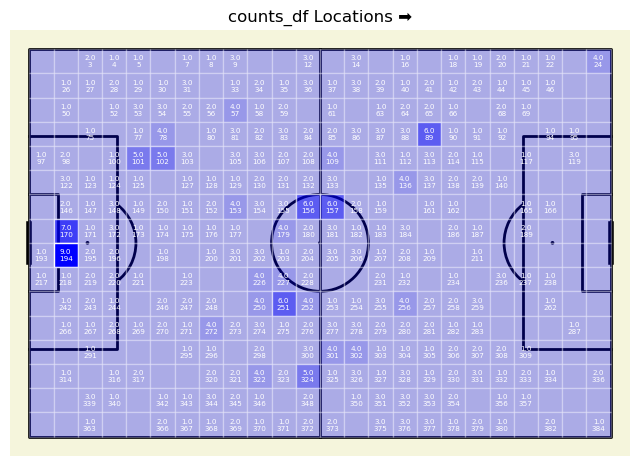

In [399]:
counts_df = shot_locations.copy()
counts_df.drop(columns=['count'], inplace=True)

display(HTML(loading_bar_html)) # loading_bar_html
actions_generated = Generate_Random_Match_Stats(72, 64, match_number=1)["pass_map"]
display(HTML("<script>updateProgressBar({})</script>".format(progress))) # loading_bar_html

data_test_series = pd.Series(dict(Counter(actions_generated))).sort_index()
counts_df['count'] = counts_df['Pitch_Number'].map(data_test_series)

def MinMaxNormalization(X):
    min_X = X.min()
    max_X = X.max()
    return (X-min_X) / (max_X-min_X)
counts_df["alpha"] = MinMaxNormalization(counts_df["count"])
counts_df['count'].fillna(0, inplace=True)

import ast
def convert_to_tuple(s):
    try:
        return ast.literal_eval(s)
    except (SyntaxError, ValueError):
        return None

counts_df['x_interval'] = counts_df['x_interval'].apply(convert_to_tuple)
counts_df['y_interval'] = counts_df['y_interval'].apply(convert_to_tuple)

ATTRIBUTE_TITLE = "counts_df"
pitch = Pitch(pitch_type='statsbomb', pitch_color='beige', line_color='black')
fig, ax = plt.subplots(figsize=(8, 12))
pitch.draw(ax=ax)

def draw_intervals(df, ax):
    for _, row in df.iterrows():
        x_start, x_end = row['x_interval']
        y_start, y_end = row['y_interval']
        count = row['count']
        percentage = round(row['count'] / df['count'].sum(), 3)
        pitch_number = row['Pitch_Number']
        alphaValue = row['alpha']
        
        # Create a rectangle patch
        rect = patches.Rectangle(
            (y_start, x_start), 
            y_end - y_start,
            x_end - x_start, 
            linewidth=1,
            edgecolor='white',
            facecolor='blue',
            alpha=max(0.3, alphaValue)
        )
        
        # Add rectangle to the plot
        ax.add_patch(rect)
        
        # Add text to the rectangles
        if count:
            ax.text(
                (y_start + y_end) / 2,
                (x_start + x_end) / 2, 
                f'{count}\n{pitch_number}', #% \n {count} \n {pitch_number}',
                ha='center', va='center',
                fontsize=5.2, color='white'
            )
draw_intervals(counts_df, ax)
plt.title(f'{ATTRIBUTE_TITLE} Locations ➡️')
saved_fig = fig.savefig(f"plots_imgs/{ATTRIBUTE_TITLE}_Locations.png", dpi=300, bbox_inches='tight')
#TESTsaved_fig = fig.savefig(f"plots_imgs/volumer.png", dpi=300, bbox_inches='tight')
print(f'{ATTRIBUTE_TITLE} is completed! ➡️')

In [365]:
location_df[location_df["Pitch_Number"] == 234].triple_prob_dict.iloc[0]

{'Pass': 0.936986301369863, 'Shot': 0.06301369863013699, 'Dribble': 0.0}

<br><br><br><br><br><br><br><br>
<h2 style="color:beige;background:blue;">  Player Pick for Actions - later</h2>

In [391]:
import sys
sys.getsizeof(location_df.to_dict())

832

In [392]:
url = "https://fbref.com/en/comps/Big5/2022-2023/shooting/players/2022-2023-Big-5-European-Leagues-Stats"
data = pd.read_html(url)
data[0].columns = data[0].columns.get_level_values(1)

In [393]:
fb = data[0]
fb.columns

Index(['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', '90s',
       'Gls', 'Sh', 'SoT', 'SoT%', 'Sh/90', 'SoT/90', 'G/Sh', 'G/SoT', 'Dist',
       'FK', 'PK', 'PKatt', 'xG', 'npxG', 'npxG/Sh', 'G-xG', 'np:G-xG',
       'Matches'],
      dtype='object')

In [394]:
fb['90s'] = pd.to_numeric(fb['90s'], errors='coerce')
fb['Sh'] = pd.to_numeric(fb['Sh'], errors='coerce')
fb['Sh/90'] = pd.to_numeric(fb['Sh/90'], errors='coerce')
fb2 = fb[fb["90s"] > 15]

In [395]:
fb_shooters = fb2.sort_values(by="Sh/90", ascending=False)[["Pos","Squad","Player","Sh","Sh/90"]]
fb_shooters.head(3)

,Pos,Squad,Player,Sh,Sh/90
2076,FW,Napoli,Victor Osimhen,132.0,4.63
1796,FW,Paris S-G,Kylian Mbappé,144.0,4.60
2018,FW,Liverpool,Darwin Núñez,84.0,4.46
